In [ ]:
pip install yfinance pandas pyportfolioopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.6 MB/s eta 0:00:00


# Data

In [ ]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting
from pypfopt import HRPOpt
from pypfopt.cla import CLA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import cvxpy as cp
import pandas as pd

In [ ]:
import yfinance as yf
symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'GOOG', 'NFLX', 'PYPL' , 'MCD']
df = yf.download(symbols, start='2024-01-01', end='2024-01-31', rounding=True)
print(df.head())
df.to_csv('portfolio_data.csv')

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  9 of 9 completed

Price      Adj Close                                                         \
Ticker          AAPL    AMZN    GOOG   GOOGL     MCD    MSFT    NFLX   PYPL   
Date                                                                          
2024-01-02    185.40  149.93  139.56  138.17  297.04  370.87  468.50  61.46   
2024-01-03    184.02  148.47  140.36  138.92  294.39  370.60  470.26  58.63   
2024-01-04    181.68  144.57  138.04  136.39  291.74  367.94  474.67  58.45   
2024-01-05    180.95  145.24  137.39  135.73  288.99  367.75  474.06  60.12   
2024-01-08    185.32  149.10  140.53  138.84  291.90  374.69  485.03  61.74   

Price                Close  ...    Open    Volume                      \
Ticker        TSLA    AAPL  ...    TSLA      AAPL      AMZN      GOOG   
Date                        ...                                         
2024-01-02  248.42  185.64  ...  250.08  82488700  47339400  20071900   
2024-01-03  238.45  184.25  ...  244.98  58414500  49425500  18974300   
20

In [ ]:
prices = df['Adj Close']

# Returns and Historical Returns

In [ ]:
returns = prices.pct_change()[1:]

In [ ]:
mean_returns = returns.mean()

In [ ]:
print(mean_returns)

Ticker
AAPL     0.000756
AMZN     0.003174
GOOG     0.004927
GOOGL    0.004907
MCD     -0.000382
MSFT     0.005139
NFLX     0.010049
PYPL     0.002284
TSLA    -0.013057
dtype: float64


In [ ]:
type_mean_returns = type(mean_returns)

In [ ]:
mean_returns_historical = expected_returns.mean_historical_return(prices, returns_data=False)

In [ ]:
mean_returns_historical

Ticker
AAPL      0.186004
AMZN      1.179337
GOOG      2.400057
GOOGL     2.380573
MCD      -0.101607
MSFT      2.613503
NFLX     10.398539
PYPL      0.601002
TSLA     -0.968104
dtype: float64

<Axes: ylabel='Ticker'>

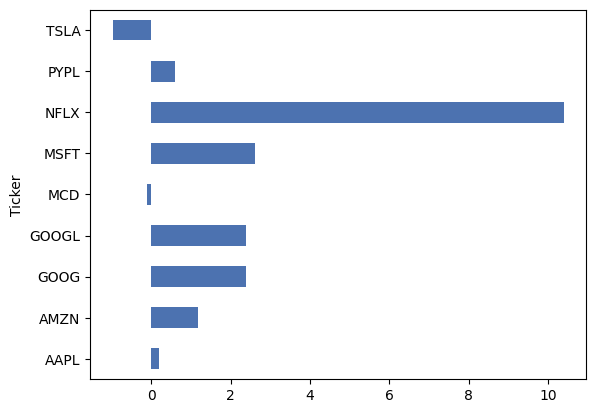

In [ ]:
mean_returns_historical.plot(kind="barh")

In [ ]:
mean_returns_ema = expected_returns.ema_historical_return(prices, returns_data=False)

In [ ]:
mean_returns_ema

Ticker
AAPL      0.202431
AMZN      1.235562
GOOG      2.465592
GOOGL     2.450972
MCD      -0.087230
MSFT      2.643419
NFLX     11.774088
PYPL      0.806256
TSLA     -0.963203
Name: 2024-01-30 00:00:00, dtype: float64

<Axes: ylabel='Ticker'>

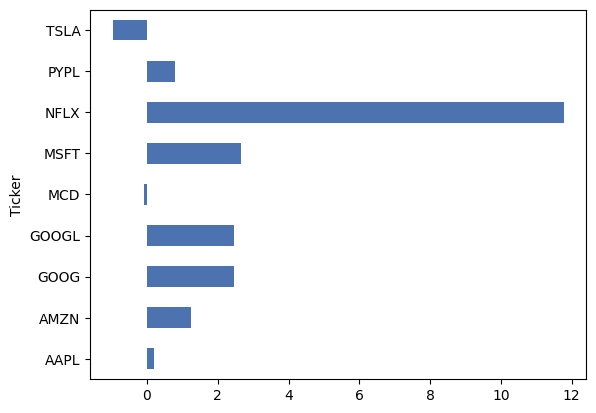

In [ ]:
mean_returns_ema.plot(kind="barh")

In [ ]:
mean_returns_capm = expected_returns.capm_return(prices, market_prices=None, returns_data=False, risk_free_rate=0.02, compounding=True, frequency=252, log_returns=False)

In [ ]:
mean_returns_capm

Ticker
AAPL     0.556402
AMZN     0.631438
GOOG     0.424034
GOOGL    0.446384
MCD      0.411789
MSFT     0.370441
NFLX     0.576924
PYPL     1.269767
TSLA     0.942410
Name: mkt, dtype: float64

<Axes: ylabel='Ticker'>

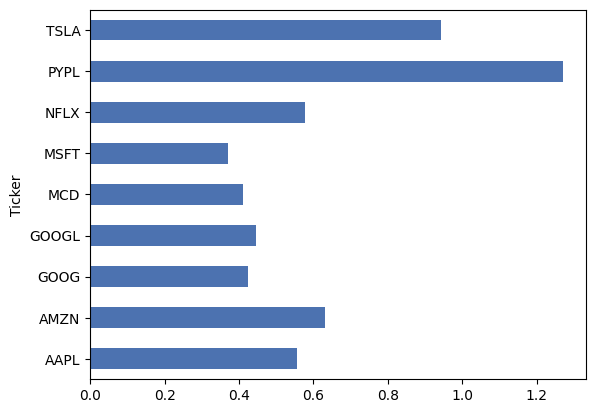

In [ ]:
mean_returns_capm.plot(kind="barh")

# COVARIANCE MATRIX

In [ ]:
covariance_matrix = returns.cov()

In [ ]:
print(covariance_matrix)

Ticker      AAPL      AMZN      GOOG     GOOGL       MCD      MSFT      NFLX  \
Ticker                                                                         
AAPL    0.000167  0.000103  0.000094  0.000094  0.000071  0.000058  0.000038   
AMZN    0.000103  0.000164  0.000112  0.000118  0.000051  0.000075  0.000083   
GOOG    0.000094  0.000112  0.000124  0.000127  0.000042  0.000063  0.000093   
GOOGL   0.000094  0.000118  0.000127  0.000131  0.000042  0.000066  0.000095   
MCD     0.000071  0.000051  0.000042  0.000042  0.000092  0.000048 -0.000014   
MSFT    0.000058  0.000075  0.000063  0.000066  0.000048  0.000060  0.000039   
NFLX    0.000038  0.000083  0.000093  0.000095 -0.000014  0.000039  0.000765   
PYPL    0.000168  0.000163  0.000043  0.000050  0.000160  0.000076 -0.000125   
TSLA    0.000011  0.000048 -0.000092 -0.000084  0.000096  0.000040 -0.000138   

Ticker      PYPL      TSLA  
Ticker                      
AAPL    0.000168  0.000011  
AMZN    0.000163  0.000048  
GOO

In [ ]:
type_covariance_matrix = type(covariance_matrix)

In [ ]:
sample_covariance_matrix = risk_models.sample_cov(prices)

<Axes: >

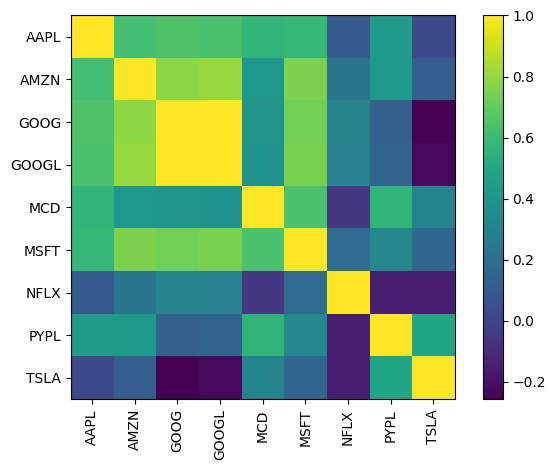

In [ ]:
sample_covariance_matrix
plotting.plot_covariance(sample_covariance_matrix, plot_correlation=True, show_tickers=True)

# Ledoit wolf matrix

In [ ]:
ledoit_wolf_covariance_matrix = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

<Axes: >

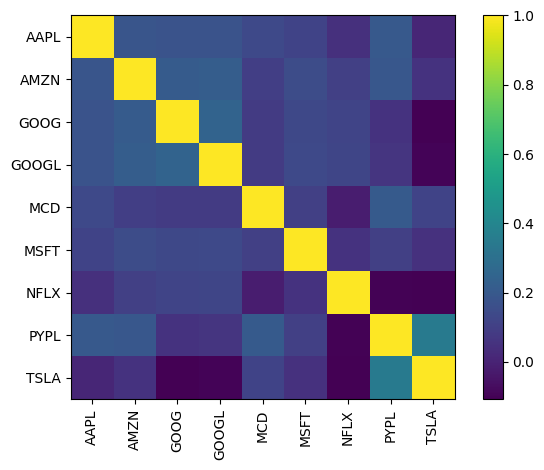

In [ ]:
ledoit_wolf_covariance_matrix
plotting.plot_covariance(ledoit_wolf_covariance_matrix, plot_correlation=True, show_tickers=True)

# Equity Curve

In [ ]:
ef = EfficientFrontier(mean_returns_historical, ledoit_wolf_covariance_matrix, weight_bounds=(0, 1))

In [ ]:
cleaned_weights_array = np.array(list(cleaned_weights.values()))

NameError: name 'cleaned_weights' is not defined

In [ ]:
portfolio_returns = np.sum(returns.values * cleaned_weights_array, axis=1)

NameError: name 'cleaned_weights_array' is not defined

In [ ]:
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

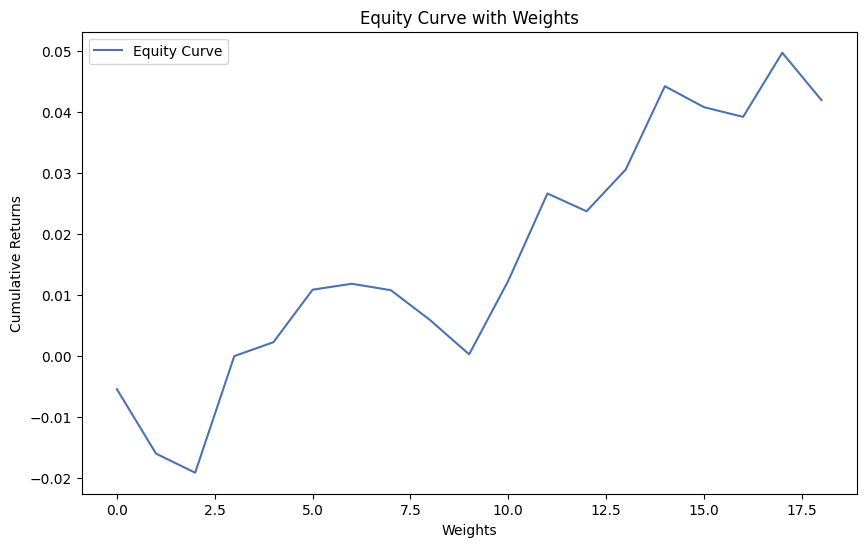

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='Equity Curve')
plt.title('Equity Curve with Weights')
plt.xlabel('Weights')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Weights and Weight Bounds

In [ ]:
ef = EfficientFrontier(mean_returns_historical, ledoit_wolf_covariance_matrix, weight_bounds=(0, 1))

In [ ]:
minimum_variance_weights = ef.min_volatility()

In [ ]:
cleaned_weights = ef.clean_weights()

<Axes: >

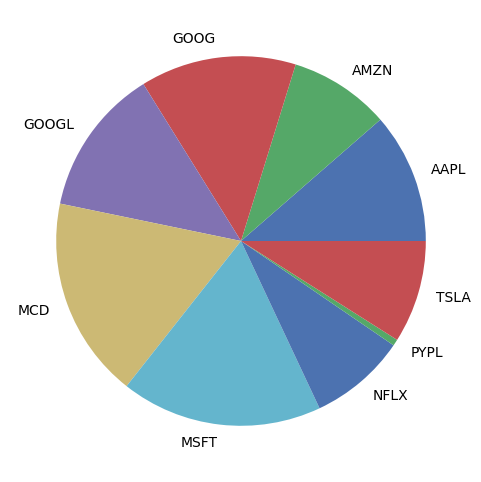

In [ ]:
pd.Series(cleaned_weights).plot(kind="pie", figsize=(6, 6))

In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 199.9%
Annual volatility: 12.2%
Sharpe Ratio: 16.28


(1.998576860590065, 0.12155825682050021, 16.27677882475514)

In [ ]:
ef = EfficientFrontier(mean_returns_historical, ledoit_wolf_covariance_matrix, weight_bounds=(0, 1))

In [ ]:
ef.efficient_risk(target_volatility=0.25)

OrderedDict([('AAPL', 9.533614e-10),
             ('AMZN', 1.5268221e-09),
             ('GOOG', 0.0638797204965203),
             ('GOOGL', 0.0545946110109881),
             ('MCD', 1.1310742e-09),
             ('MSFT', 0.2160533007447259),
             ('NFLX', 0.6438818442956988),
             ('PYPL', 0.0215905184633507),
             ('TSLA', 1.3764607e-09)])

In [ ]:
weights = ef.clean_weights()

In [ ]:
weights

OrderedDict([('AAPL', 0.0),
             ('AMZN', 0.0),
             ('GOOG', 0.06388),
             ('GOOGL', 0.05459),
             ('MCD', 0.0),
             ('MSFT', 0.21605),
             ('NFLX', 0.64388),
             ('PYPL', 0.02159),
             ('TSLA', 0.0)])

<Axes: >

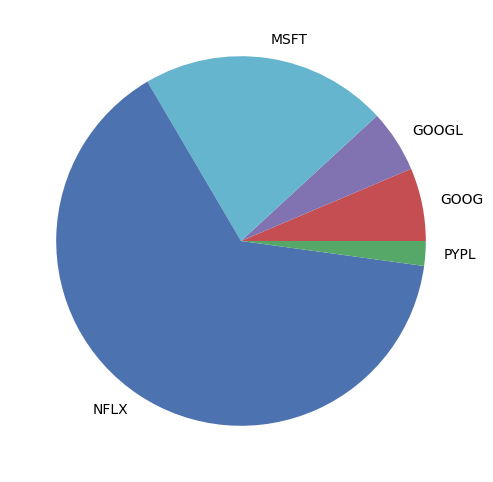

In [ ]:
pd.Series(weights).plot(kind="pie", figsize=(6, 6))

In [ ]:
ef = EfficientFrontier(mean_returns_historical, ledoit_wolf_covariance_matrix, weight_bounds=(0, 1))

In [ ]:
ef.efficient_return(target_return=0.25)

OrderedDict([('AAPL', 0.1140285147251603),
             ('AMZN', 0.0881496038901438),
             ('GOOG', 0.1364008045384112),
             ('GOOGL', 0.1289679172407176),
             ('MCD', 0.1762047464435064),
             ('MSFT', 0.1761395417152483),
             ('NFLX', 0.0846491646902196),
             ('PYPL', 0.0055900923947487),
             ('TSLA', 0.0898696143618441)])

In [ ]:
weights = ef.clean_weights()

In [ ]:
weights

OrderedDict([('AAPL', 0.11403),
             ('AMZN', 0.08815),
             ('GOOG', 0.1364),
             ('GOOGL', 0.12897),
             ('MCD', 0.1762),
             ('MSFT', 0.17614),
             ('NFLX', 0.08465),
             ('PYPL', 0.00559),
             ('TSLA', 0.08987)])

<Axes: >

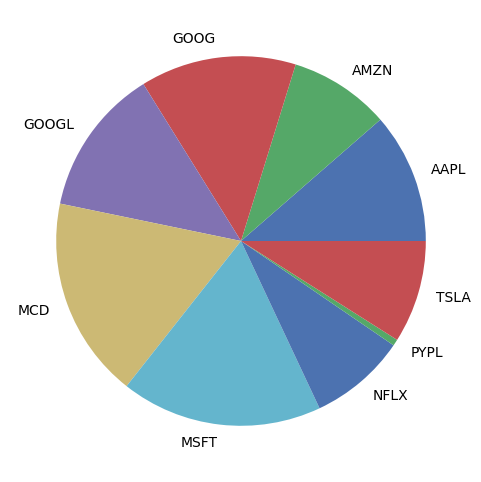

In [ ]:
pd.Series(weights).plot(kind="pie", figsize=(6, 6))

In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 199.9%
Annual volatility: 12.2%
Sharpe Ratio: 16.28


(1.998576860590065, 0.1215582568205002, 16.27677882475514)

###Mean Variance Optimization

In [ ]:
ef = EfficientFrontier(mean_returns_historical, ledoit_wolf_covariance_matrix, weight_bounds=(-1, 1))

In [ ]:
print("Mean-Variance Optimization Weights:")
print(weights)

Mean-Variance Optimization Weights:
OrderedDict([('AAPL', 0.11403), ('AMZN', 0.08815), ('GOOG', 0.1364), ('GOOGL', 0.12897), ('MCD', 0.1762), ('MSFT', 0.17614), ('NFLX', 0.08465), ('PYPL', 0.00559), ('TSLA', 0.08987)])


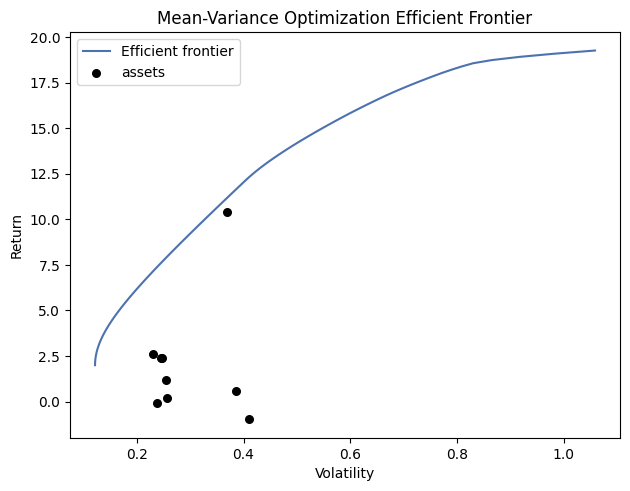

In [ ]:
plotting.plot_efficient_frontier(ef, show_assets=True)
plt.title("Mean-Variance Optimization Efficient Frontier")
plt.show()

###Minimum Volatility Optimization

In [ ]:
ef = EfficientFrontier(mean_returns_historical, ledoit_wolf_covariance_matrix, weight_bounds=(0, 1))

In [ ]:
print("Minimum Volatility Optimization Weights:")
print(weights)

Minimum Volatility Optimization Weights:
OrderedDict([('AAPL', 0.11403), ('AMZN', 0.08815), ('GOOG', 0.1364), ('GOOGL', 0.12897), ('MCD', 0.1762), ('MSFT', 0.17614), ('NFLX', 0.08465), ('PYPL', 0.00559), ('TSLA', 0.08987)])


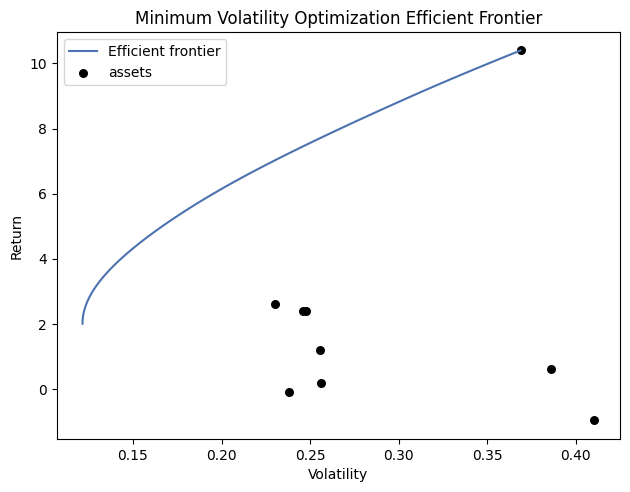

In [ ]:
plotting.plot_efficient_frontier(ef, show_assets=True)
plt.title("Minimum Volatility Optimization Efficient Frontier")
plt.show()

##Hierarical risk Parity

In [ ]:
hrp = HRPOpt(returns)

In [ ]:
hrp.optimize()

OrderedDict([('AAPL', 0.09268790646849501),
             ('AMZN', 0.08179365282264026),
             ('GOOG', 0.054192407658490815),
             ('GOOGL', 0.051399639349372805),
             ('MCD', 0.32359914591801514),
             ('MSFT', 0.25657200196945545),
             ('NFLX', 0.061008354490120535),
             ('PYPL', 0.03391858454379685),
             ('TSLA', 0.04482830677961314)])

In [ ]:
weights = hrp.clean_weights()

In [ ]:
weights

OrderedDict([('AAPL', 0.09269),
             ('AMZN', 0.08179),
             ('GOOG', 0.05419),
             ('GOOGL', 0.0514),
             ('MCD', 0.3236),
             ('MSFT', 0.25657),
             ('NFLX', 0.06101),
             ('PYPL', 0.03392),
             ('TSLA', 0.04483)])

<Axes: >

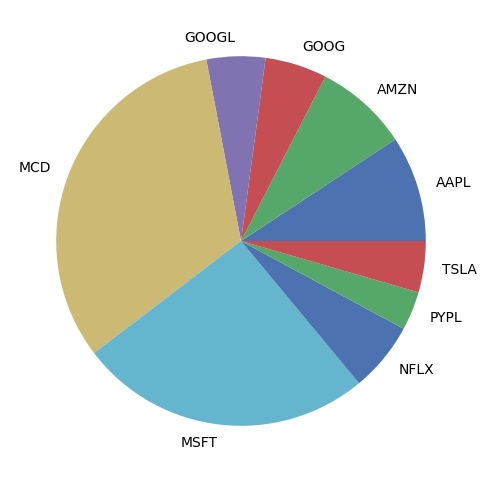

In [ ]:
pd.Series(weights).plot(kind="pie", figsize=(6, 6))

In [ ]:
hrp.portfolio_performance(verbose=True)

Expected annual return: 54.2%
Annual volatility: 13.3%
Sharpe Ratio: 3.93


(0.541576203490151, 0.13256846495738048, 3.9343912118001283)

<Axes: >

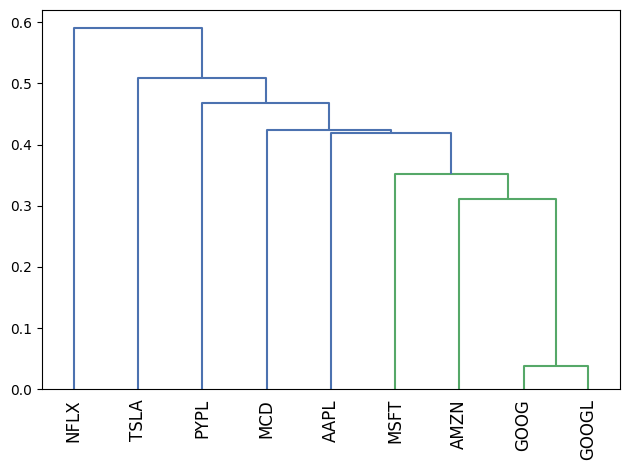

In [ ]:
plotting.plot_dendrogram(hrp)

#### Enhancing the Portfolio Optimization by introducing some parameters

In [ ]:
ef = EfficientFrontier(mean_returns_historical, ledoit_wolf_covariance_matrix, weight_bounds=(0, 1))

In [ ]:
ef.add_objective(objective_functions.L2_reg, gamma=0.1)

In [ ]:
ef.efficient_risk(target_volatility=0.25)

OrderedDict([('AAPL', 3.94123e-10),
             ('AMZN', 6.763506e-10),
             ('GOOG', 0.0655045549084738),
             ('GOOGL', 0.0565420315201652),
             ('MCD', 4.608606e-10),
             ('MSFT', 0.2126970623265806),
             ('NFLX', 0.6439142374689988),
             ('PYPL', 0.0213421116724015),
             ('TSLA', 5.643529e-10)])

In [ ]:
weights = ef.clean_weights()

In [ ]:
weights

OrderedDict([('AAPL', 0.0),
             ('AMZN', 0.0),
             ('GOOG', 0.0655),
             ('GOOGL', 0.05654),
             ('MCD', 0.0),
             ('MSFT', 0.2127),
             ('NFLX', 0.64391),
             ('PYPL', 0.02134),
             ('TSLA', 0.0)])

<Axes: >

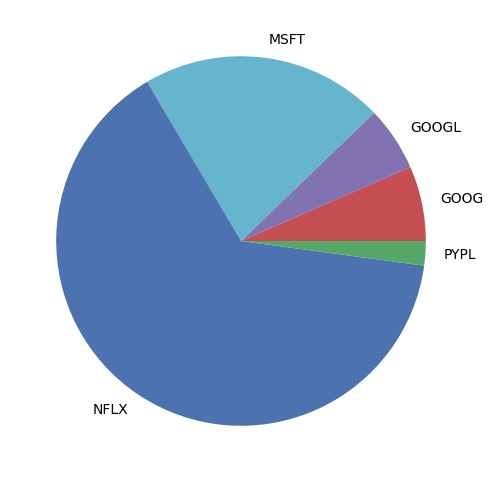

In [ ]:
pd.Series(weights).plot(kind="pie", figsize=(6, 6))

<Axes: >

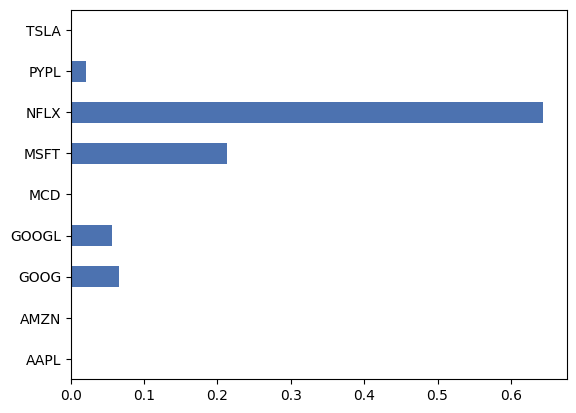

In [ ]:
pd.Series(weights).plot(kind="barh")

In [ ]:
ef = EfficientFrontier(mean_returns_historical, ledoit_wolf_covariance_matrix, weight_bounds=(-1, 1))

In [ ]:
ef.add_objective(objective_functions.L2_reg, gamma=0.1)

In [ ]:
ef.efficient_risk(target_volatility=0.25, market_neutral=True)

OrderedDict([('AAPL', -0.2776139633972099),
             ('AMZN', -0.1702236222515875),
             ('GOOG', 0.0171099346024203),
             ('GOOGL', 0.0135980512505622),
             ('MCD', -0.2967631507410441),
             ('MSFT', 0.1399940893303931),
             ('NFLX', 0.5954636853635094),
             ('PYPL', 0.0955960084165962),
             ('TSLA', -0.1171610325740196)])

In [ ]:
weights = ef.clean_weights()

In [ ]:
weights

OrderedDict([('AAPL', -0.27761),
             ('AMZN', -0.17022),
             ('GOOG', 0.01711),
             ('GOOGL', 0.0136),
             ('MCD', -0.29676),
             ('MSFT', 0.13999),
             ('NFLX', 0.59546),
             ('PYPL', 0.0956),
             ('TSLA', -0.11716)])

<Axes: xlabel='Weight'>

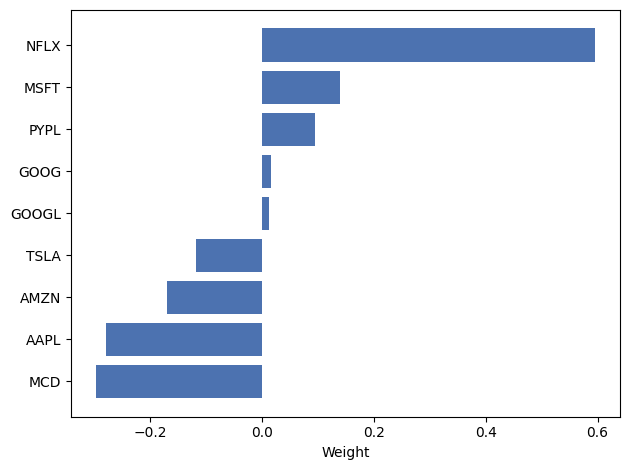

In [ ]:
plotting.plot_weights(weights)

In [ ]:
ef = EfficientFrontier(mean_returns_historical, ledoit_wolf_covariance_matrix)

In [ ]:
NFLX_pos = ef.tickers.index('NFLX')

In [ ]:
ef.add_constraint(lambda w: w[NFLX_pos] == 0.20)

In [ ]:
TSLA_pos = ef.tickers.index('TSLA')

In [ ]:
ef.add_constraint(lambda w: w[TSLA_pos] >= 0.05)

In [ ]:
ef.add_constraint(lambda w: w[2] <= 0.4)

In [ ]:
ef.max_sharpe()

OrderedDict([('AAPL', 0.0),
             ('AMZN', 0.0280645573534853),
             ('GOOG', 0.197056331443374),
             ('GOOGL', 0.1865609633451029),
             ('MCD', 0.0168320455484846),
             ('MSFT', 0.2955558164196047),
             ('NFLX', 0.2),
             ('PYPL', 0.0259302858899485),
             ('TSLA', 0.05)])

In [ ]:
ef = EfficientFrontier(mean_returns_historical, ledoit_wolf_covariance_matrix)

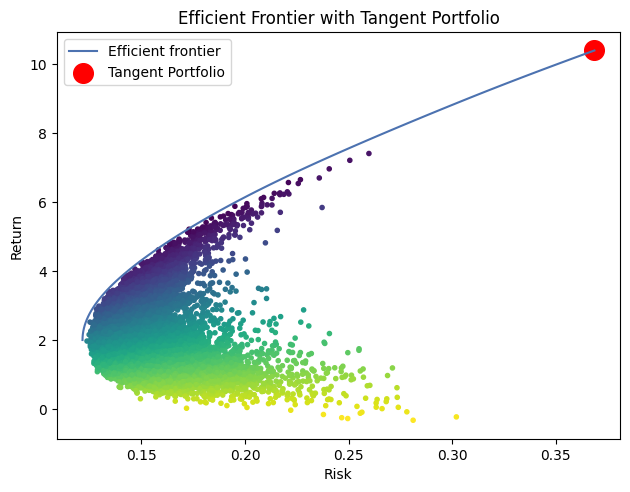

In [ ]:
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, show_assets=False)
n_portfolios = 10000
weights = np.random.dirichlet(np.ones(len(prices.columns)), n_portfolios)
returns_portfolio = weights.dot(mean_returns_historical)
risk_portfolio = np.sqrt(np.diag(weights @ ledoit_wolf_covariance_matrix @ weights.T))
sharpes_portfolio = returns_portfolio / risk_portfolio
ax.scatter(risk_portfolio, returns_portfolio, marker=".", c=sharpes_portfolio, cmap="viridis_r")


return_tangent, risk_tangent, _ = ef.portfolio_performance()
ax.scatter(risk_tangent, return_tangent, marker="o", s=200, c="r", label="Tangent Portfolio")

ax.set_title("Efficient Frontier with Tangent Portfolio")
ax.legend()
plt.ylabel("Return")
plt.xlabel("Risk")
plt.show()

# Critical Line Algorithm

In [ ]:
cla = CLA(mean_returns_historical, ledoit_wolf_covariance_matrix)

In [ ]:
weights_cla = cla.max_sharpe()

In [ ]:
print("Optimized Weights (CLA):")
print(weights_cla)

Optimized Weights (CLA):
OrderedDict([('AAPL', 0.0), ('AMZN', 0.0), ('GOOG', 0.1140136964167768), ('GOOGL', 0.10486176097970368), ('MCD', 0.0), ('MSFT', 0.2438808326839614), ('NFLX', 0.485545954725332), ('PYPL', 0.051697755194226355), ('TSLA', 1.8177444098305224e-17)])


<Axes: xlabel='Weight'>

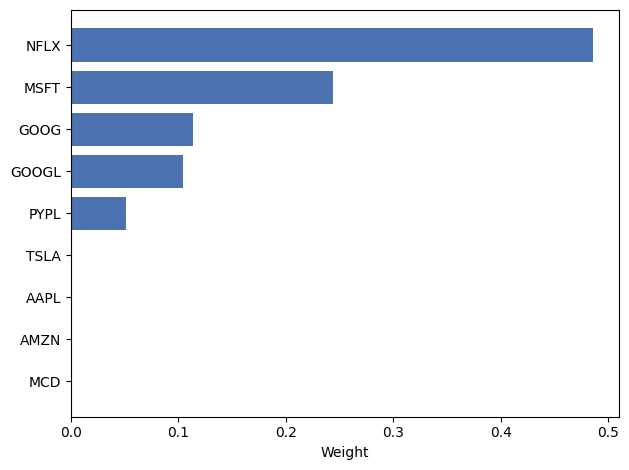

In [ ]:
plotting.plot_weights(weights_cla)

In [ ]:
print(type(returns.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [ ]:
cla = CLA(mean_returns_historical, ledoit_wolf_covariance_matrix)

In [ ]:
weights_cla = cla.max_sharpe()

In [ ]:
weights_array = np.array(list(weights_cla.values()))

In [ ]:
cla_returns = np.dot(returns.values, weights_cla)
cla_cumulative_returns = (1 + cla_returns).cumprod() - 1

TypeError: unsupported operand type(s) for *: 'float' and 'collections.OrderedDict'

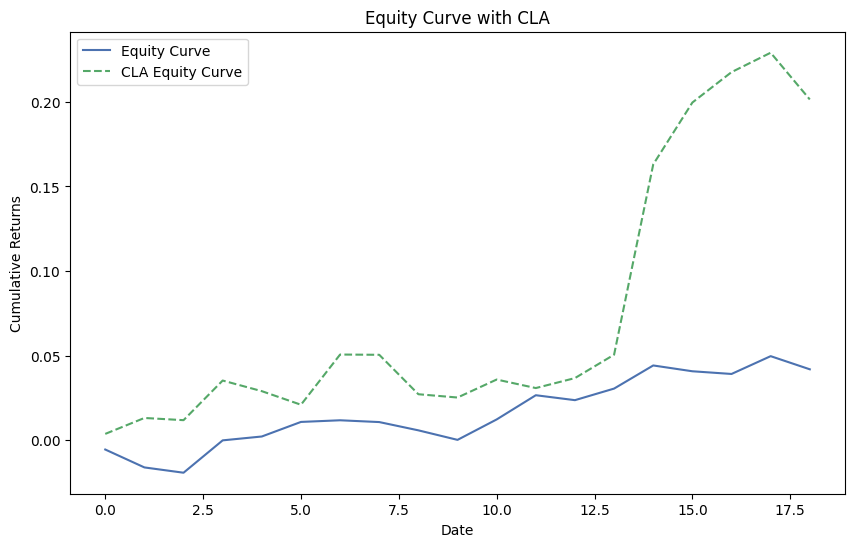

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='Equity Curve')
plt.plot(cla_cumulative_returns, label='CLA Equity Curve', linestyle='--')
plt.title('Equity Curve with CLA')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [ ]:
portfolio_returns_cla = np.dot(returns.values, cla_weights)
cumulative_returns_cla = (1 + portfolio_returns_cla).cumprod() - 1

NameError: name 'cla_weights' is not defined

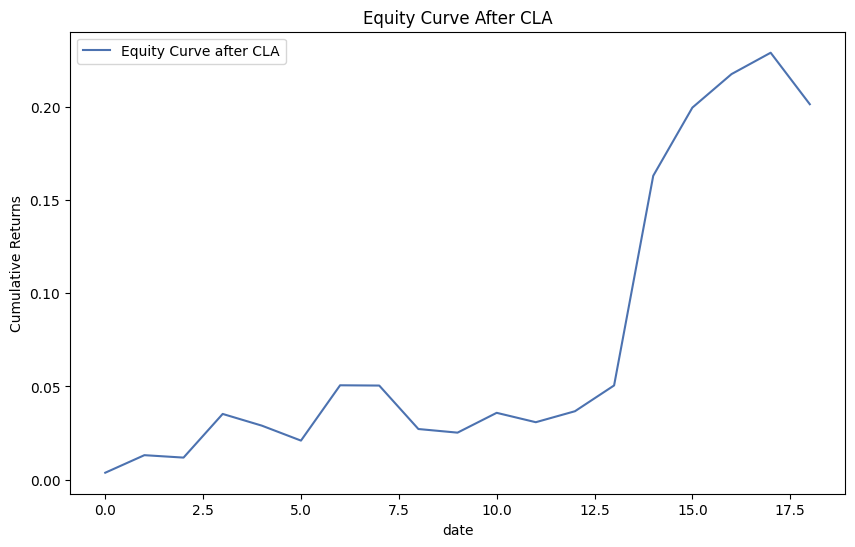

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns_cla, label='Equity Curve after CLA', linestyle='-')
plt.title('Equity Curve After CLA')
plt.xlabel('date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Future predictions

In [ ]:
pip install statsmodels

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
stock_data = df['Close']

In [ ]:
stock_data_array = stock_data.values.flatten()
result = adfuller(stock_data_array)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -0.004099374653746492
p-value: 0.9581917548109092


In [ ]:
order = (5, 3, 1)
arima_model = ARIMA(stock_data, order=order)
arima_fit = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ValueError: SARIMAX models require univariate `endog`. Got shape (20, 9).

NameError: name 'forecast_mean' is not defined

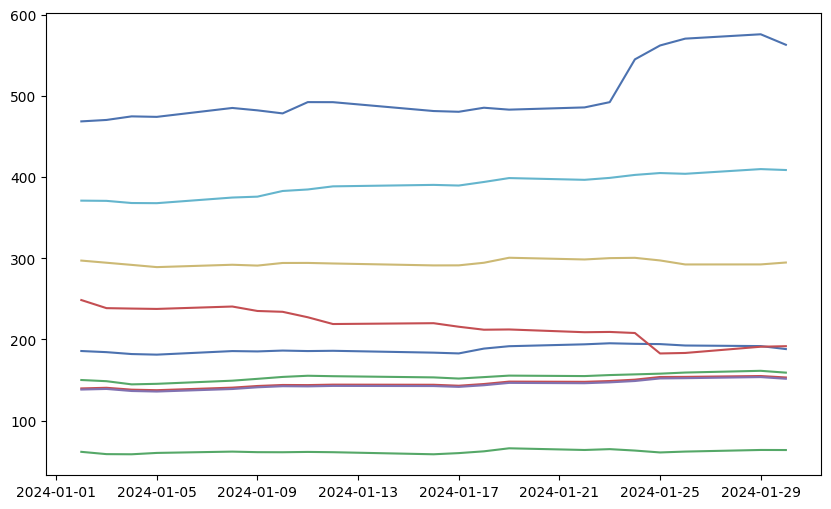

In [ ]:
stock_data.index = pd.to_datetime(stock_data.index)

plt.figure(figsize=(10, 6))
plt.plot(stock_data, label='Observed')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2, label='Confidence Interval')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xlim(pd.Timestamp('2024-01-01'), pd.Timestamp('2024-03-01'))
plt.legend()
plt.show()

In [ ]:
stock_data_diff = df['Close']

In [ ]:
stock_data_diff_univariate = stock_data_diff.iloc[:, 0]

In [ ]:
order = (5, 3, 1)
arima_model = ARIMA(stock_data_diff_univariate, order=order)
arima_fit = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
forecast_horizon = 30
forecast_dates = pd.date_range(start=stock_data.index[-1], periods=forecast_horizon + 1, freq='B')[1:]

In [ ]:
forecast_results = arima_fit.get_forecast(steps=forecast_horizon, alpha=0.05)
forecast_mean = forecast_results.predicted_mean
forecast_ci = forecast_results.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


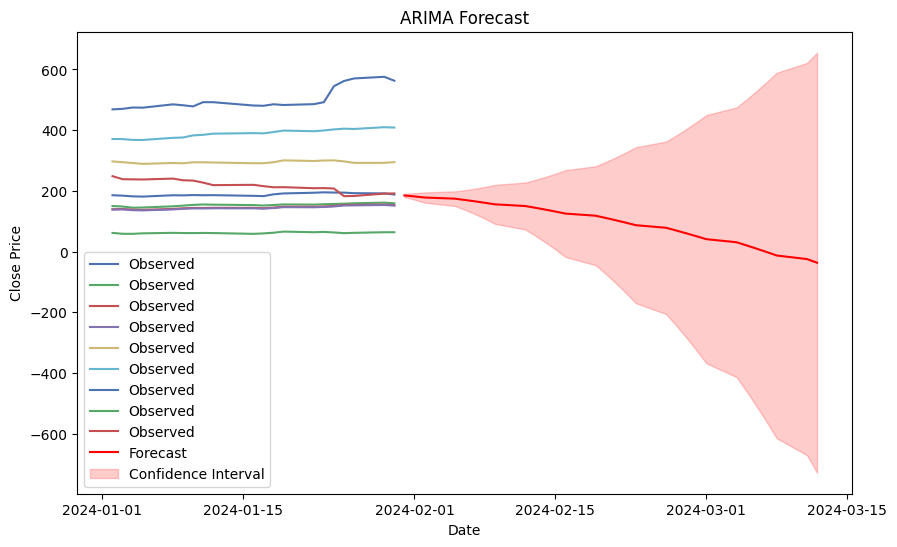

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(stock_data, label='Observed')
plt.plot(forecast_dates, forecast_mean, color='red', label='Forecast')
plt.fill_between(forecast_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2, label='Confidence Interval')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
print("Observed Data:")
print(stock_data)

print("\nForecast Data:")
print("Forecast Mean:")
print(forecast_mean)

print("\nForecast Confidence Interval:")
print(forecast_ci)

Observed Data:
Ticker        AAPL    AMZN    GOOG   GOOGL     MCD    MSFT    NFLX   PYPL  \
Date                                                                        
2024-01-02  185.64  149.93  139.56  138.17  297.04  370.87  468.50  61.46   
2024-01-03  184.25  148.47  140.36  138.92  294.39  370.60  470.26  58.63   
2024-01-04  181.91  144.57  138.04  136.39  291.74  367.94  474.67  58.45   
2024-01-05  181.18  145.24  137.39  135.73  288.99  367.75  474.06  60.12   
2024-01-08  185.56  149.10  140.53  138.84  291.90  374.69  485.03  61.74   
2024-01-09  185.14  151.37  142.56  140.95  290.87  375.79  482.09  61.05   
2024-01-10  186.19  153.73  143.80  142.28  294.09  382.77  478.33  60.96   
2024-01-11  185.59  155.18  143.67  142.08  294.15  384.63  492.23  61.35   
2024-01-12  185.92  154.62  144.24  142.65  293.47  388.47  492.16  61.00   
2024-01-16  183.63  153.16  144.08  142.49  291.09  390.27  481.24  58.45   
2024-01-17  182.68  151.71  142.89  141.47  291.16  389.47  4

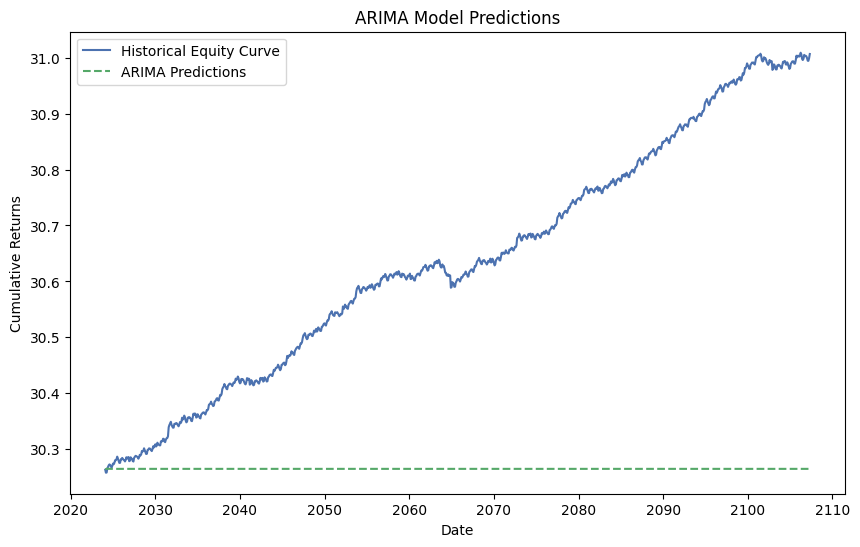

In [ ]:
test_df = pd.DataFrame({'Values': test})
start_date = pd.to_datetime('2024-01-01')

frequency = 'M'
total_periods = len(test)

max_periods = 1000
total_periods = min(total_periods, max_periods)

date_range = pd.date_range(start=start_date, periods=total_periods, freq=frequency)

test_df = test_df.head(total_periods)
test_df.index = date_range

plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df['Values'], label='Historical Equity Curve')
plt.plot(test_df.index, predictions[:total_periods], label='ARIMA Predictions', linestyle='--')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()